**Course website**: http://www.leouieda.com/geofisica1

**Note**: This notebook is part of the course "Geofísica 1" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [Jupyter notebook](http://jupyter.org/). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (números, texto, figuras, videos, etc).

# Prática 7 - Magnetometria - Transformada de Fourier e derivadas

## Objetivos

* Visualizar os efeitos e resultados da Transformada de Fourier em sinais simples.
* Aplicar a Transformada de Fourier para calcular derivadas da anomalia magnética de campo total.
* Observar os efeitos do erro aleatório nas derivadas calculadas.

## Instruções

O notebook te fornecerá exemplos interativos que trabalham os temas abordados no questionário. Utilize esses exemplos para responder as perguntas.

As células com números ao lado, como `In [1]:`, são código [Python](http://python.org/). Algumas dessas células não produzem resultado e servem de preparação para os exemplos interativos. Outras, produzem gráficos interativos. **Você deve executar todas as células, uma de cada vez**, mesmo as que não produzem gráficos.

Para executar uma célula, clique em cima dela e aperte `Shift + Enter`. O foco (contorno verde ou cinza em torno da célula) deverá passar para a célula abaixo. Para rodá-la, aperte `Shift + Enter` novamente e assim por diante. Você pode executar células de texto que não acontecerá nada.

In [ ]:
%matplotlib inline
from __future__ import division
from IPython.html import widgets
import numpy as np
from fatiando.gravmag import prism, fourier
from fatiando import utils, gridder, mesher
from fatiando.vis import mpl
import fatiando
mpl.rc('lines', linewidth=2)
mpl.rc('font', size=12)

In [41]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn
import fatiando
from fatiando import gridder, mesher, utils
from fatiando.gravmag import prism
from fatiando.vis import mpl
seaborn.set_context('talk')

In [2]:
print('Versão do Fatiando a Terra: {}'.format(fatiando.__version__))

Versão do Fatiando a Terra: 0.3-325-g9d7eb93


## Tranformada de Fourier

A primeira tarefa servirá para ilustrar o conceito de [Transformada de Fourier](http://en.wikipedia.org/wiki/Fourier_transform) que vimos na aula teórica.

Como vimos em aula, uma função $h(t)$ pode ser escrita como:

$$
h(t) = \int\limits_{-\infty}^{\infty} H(f)\ e^{i 2 \pi f t}df
$$

em que $f$ é a frequência. $e^{i 2 \pi f t}$ são "coisas" que oscilam com frequência $f$ pois

$$
e^{i 2 \pi f t} = \cos(2 \pi f t) + i\sin(2 \pi f t)
$$

A equação da transformada nos diz que a função $h(t)$ pode ser escrita como uma "soma" infinita de oscilações de frequências diferentes.
A oscilação de frequência $f$ possui uma amplitude $H(f)$. A função que descreve as amplitudes, $H(f)$, é a **Transformada de Fourier**. Podemos calcular a transformada $H(f)$ da função utilizando a fórmula abaixo:

$$
H(f) = \int\limits_{-\infty}^{\infty} h(t)\ e^{-i 2 \pi f t}dt
$$

$H(f)$ é um número complexo. É comum fazer um gráfico do módulo da transformada $|H(f)|$ pela frequência. Esse gráfico é chamado de **espectro de amplitudes**.

**Rode a célula abaixo para gerar uma figura interativa.**

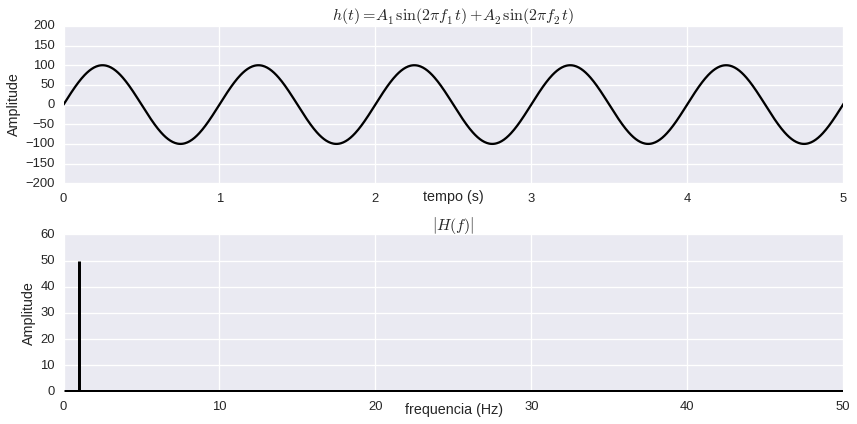

In [51]:
def dois_senos(f1, A1, f2, A2):
    sample = 1/200
    t = np.arange(0, 10, sample)
    n = t.size
    s = A1*np.sin(2*np.pi*f1*t) + A2*np.sin(2*np.pi*f2*t)
    f = np.fft.fftfreq(n, sample)[:n//2]
    S = np.fft.fft(s)[:n//2]/n
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(211)
    plt.title(r'$h(t) = A_1 \sin(2\pi f_1 t) + A_2 \sin(2\pi f_2 t)$', fontsize=16)
    plt.plot(t, s, '-k')
    plt.xlim(0, 5)
    plt.ylim(-200, 200)
    ax.set_xlabel('tempo (s)', labelpad=-15)
    plt.ylabel('Amplitude')
    ax = plt.subplot(212)
    plt.title(r'$|H(f)|$', fontsize=16)
    plt.vlines(f, [0], np.abs(S), colors='k', linewidth=3)
    plt.hlines(0, f.min(), f.max(), colors='k', linewidth=5)
    plt.xlim(0, 50)
    plt.ylim(0, 60)
    ax.set_xlabel('frequencia (Hz)', labelpad=-10)
    plt.ylabel('Amplitude')
    plt.tight_layout()
widgets.interactive(dois_senos, 
                    f1=widgets.IntSlider(min=1, max=40, step=1, value=1), 
                    A1=widgets.IntSlider(min=0, max=100, step=10, value=100), 
                    f2=widgets.IntSlider(min=1, max=40, step=1, value=10), 
                    A2=widgets.IntSlider(min=0, max=100, step=10, value=0))

### Sobre a figura

* A figura de **cima** mostra a função $h(t)$ que é composta por dois senos.
* Os **botões** controlam a amplitude e frequência de cada seno.
* A figura de **baixo** mostra o módulo Transformada de Fourier (espectro de amplitudes) da função $h(t)$. O espectro foi calculado a partir de dados da função $h(t)$ (pontos em uma tabela). 

## Tarefa 3: Derivada total

Outra operação que a Transformada de Fourier nos permite fazer é calcular derivadas dos nossos dados. Uma transformação muito utilizada na magnetometria é a Derivada Total (DT):

$$
DT = \sqrt{\left(\frac{\partial T}{\partial x}\right)^2 + \left(\frac{\partial T}{\partial y}\right)^2 + \left(\frac{\partial T}{\partial z}\right)^2}
$$

A DT é famosa por concentrar a anomalia magnética de campo total sobre o corpo causador da anomalia.

As derivadas parciais na equação acima podem ser calculadas da anomalia de campo total ($T$) usando a Transformada de Fourier.
Derivando a equação de $h(t)$ acima:

$$
\frac{\partial h}{\partial t} = \frac{\partial}{\partial t}\left(\int\limits_{-\infty}^{\infty} H(f)\ e^{i 2 \pi f t}df\right)
$$

Como a única coisa que depende de $t$ é $e^{i 2 \pi f t}$, podemos passar a derivada para dentro da integral:

$$
\frac{\partial h}{\partial t} = \int\limits_{-\infty}^{\infty} H(f)\ \frac{\partial e^{i 2 \pi f t}}{\partial t}df
$$

e aplicando a [regra da cadeia](http://en.wikipedia.org/wiki/Chain_rule)

$$
\frac{\partial h}{\partial t} = \int\limits_{-\infty}^{\infty} H(f)\ i 2 \pi f\ e^{i 2 \pi f t} df
$$

$\frac{\partial h}{\partial t}$ também é uma função e pode ser escrita como a soma de infinitas oscilações. Se chamarmos a transformada de Fourier de uma função $h$ de $F\{h\}$, podemos escrever a derivada de $h$ como:

$$
\frac{\partial h}{\partial t} = \int\limits_{-\infty}^{\infty} F\left\{\frac{\partial h}{\partial t}\right\}e^{i 2 \pi f t} df
$$

Se compararmos as duas equações acima, vemos que

$$
F\left\{\frac{\partial h}{\partial t}\right\} = H(f)\ i 2 \pi f
$$

Ou seja, a transformada de Fourier da derivada é $i 2 \pi f$ vezes a transformada de Fourier da função. Uma vez tendo a transformada da derivada, podemos calcular a derivada.

**Rode a célula abaixo para gerar uma figura interativa.**

In [ ]:
shape = (100, 100)
x, y, z = gridder.regular((-5000, 5000, -5000, 5000), shape, z=0)
dx, dy = 500, 5000
cubo = mesher.Prism(-dy/2, dy/2, -dx/2, dx/2, 400, 4000)
cubo_area = cubo.get_bounds()[:4][::-1]
def derivada_total(inc, dec, erro):
    tf = prism.tf(x, y, z, [cubo], inc, dec, pmag=utils.ang2vec(1, inc, dec))
    if erro > 0:
        tf = utils.contaminate(tf, erro, seed=0)
    total = fourier.ansig(x, y, tf, shape)
    fig, axes = mpl.subplots(1, 2, figsize=(14, 6))
    for ax, data, title in zip(axes.ravel(), [tf, total], ['Anomalia', 'Derivada Total']):
        ax.set_aspect('equal')
        mpl.sca(ax)
        mpl.title(title)
        mpl.square(cubo_area)
        scale = np.abs([data.min(), data.max()]).max()
        mpl.contourf(y, x, data, shape, 30, cmap=mpl.cm.RdBu_r, vmin=-scale, vmax=scale)
        if title != "Anomalia":
            mpl.colorbar(pad=0).set_label('nT/m')
        else:
            mpl.colorbar(pad=0).set_label('nT')                
        mpl.m2km()
    mpl.tight_layout(h_pad=0, w_pad=0)    
widgets.interactive(derivada_total, 
                    inc=widgets.IntSliderWidget(min=-90, max=90, step=5, value=45),
                    dec=widgets.IntSliderWidget(min=-90, max=90, step=5, value=0),
                    erro=widgets.FloatSliderWidget(min=0, max=20, step=1, value=0))

### Sobre a figura

* A figura da **esquerda** mostra a anomalia magnética de campo total causada por um paralelepípedo (contorno preto).
* A figura da **direita** mostra a derivada total (DT) da anomalia da esquerda calculada com a Transformada de Fourier.
* Os **botões** controlam a inclinação e declinação do campo da Terra (`inc` e `dec`) e o erro colocado nos dados originais (da esquerda).

### Tarefas e perguntas

1. Mantenha a inclinação em 45º e declinação em 0. Aumente o erro aplicado aos dados.
    * O que acontece com a Derivada Total quando o erro aumenta? Por que acontece isso? Dica: olhe as equações acima.
2. Varie a inclinação e a declinação.
    * A DT varia com a inclinação?
    * A DT continua concentrada em cima do corpo para qualquer inclinação?
    * Se a inclinação for 0, o que acontece com a DT quando a declinação varia até $\pm90$?